### Potato image classification

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
EPOCHS = 5

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle   = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2021-11-13 15:53:27.829706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print (image_batch[0])
    #print (label_batch.numpy())

2021-11-13 15:53:27.954304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(
[[[210. 208. 219.]
  [195. 193. 204.]
  [173. 171. 182.]
  ...
  [143. 141. 154.]
  [141. 139. 152.]
  [138. 136. 149.]]

 [[176. 174. 185.]
  [195. 193. 204.]
  [181. 179. 190.]
  ...
  [149. 147. 160.]
  [143. 141. 154.]
  [132. 130. 143.]]

 [[184. 182. 193.]
  [195. 193. 204.]
  [164. 162. 173.]
  ...
  [155. 153. 166.]
  [144. 142. 155.]
  [127. 125. 138.]]

 ...

 [[166. 164. 177.]
  [158. 156. 169.]
  [157. 155. 168.]
  ...
  [111. 109. 120.]
  [ 98.  96. 107.]
  [104. 102. 113.]]

 [[159. 157. 170.]
  [159. 157. 170.]
  [158. 156. 169.]
  ...
  [ 98.  96. 107.]
  [ 83.  81.  92.]
  [ 91.  89. 100.]]

 [[154. 152. 165.]
  [163. 161. 174.]
  [162. 160. 173.]
  ...
  [121. 119. 130.]
  [110. 108. 119.]
  [121. 119. 130.]]], shape=(256, 256, 3), dtype=float32)


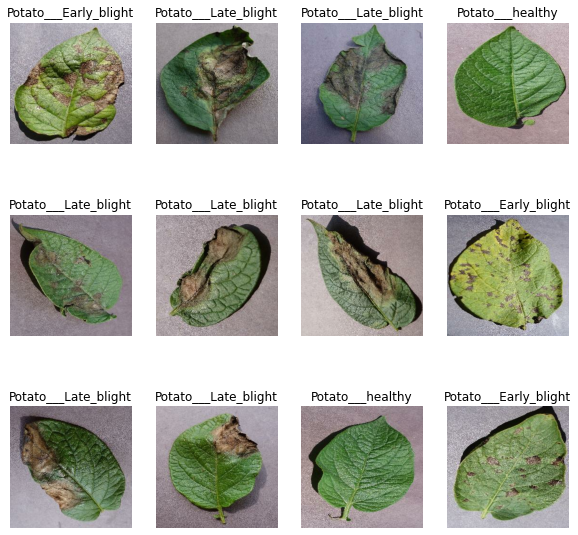

In [7]:
#visualize just some image
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#split dataset 
#Training, validating and test 

In [9]:
def get_dataset_partisions_tf(ds, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle =True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(ds_size *train_split)
    val_size = int(ds_size *val_split)
    
    train_ds = dataset.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds, test_ds

In [10]:
train_ds,val_ds, test_ds = get_dataset_partisions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds   = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
#resizeing 

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [14]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Modeling 

In [15]:
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes =3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation= 'relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation ='softmax'),
    
])

model.build(input_shape= input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history =model.fit(
     train_ds,
     epochs= EPOCHS,
     batch_size=BATCH_SIZE,
     verbose= 1,
     validation_data= val_ds
)

Epoch 1/5
54/54 [==============================] - 73s 1s/step - loss: 0.9488 - accuracy: 0.4630 - val_loss: 0.9003 - val_accuracy: 0.5417
Epoch 2/5
54/54 [==============================] - 67s 1s/step - loss: 0.8664 - accuracy: 0.5214 - val_loss: 0.8272 - val_accuracy: 0.5536
Epoch 3/5
54/54 [==============================] - 60s 1s/step - loss: 0.7367 - accuracy: 0.6476 - val_loss: 0.5789 - val_accuracy: 0.7262
Epoch 4/5
54/54 [==============================] - 60s 1s/step - loss: 0.5459 - accuracy: 0.7685 - val_loss: 0.5769 - val_accuracy: 0.7679
Epoch 5/5
54/54 [==============================] - 60s 1s/step - loss: 0.3927 - accuracy: 0.8391 - val_loss: 0.3644 - val_accuracy: 0.8512
